## Ejercicio: Modificar el programa completo para en entrenamiento, validación y test con 7 clases 
## Solución

**Carga y descompresión de datos**

In [1]:
#@title Desarga y descompresión de datos
data_id = "variedades" #@param ["variedades", "olivenet"]

correspond = {'variedades': '1nM-EhT6ejaYtDbAvm0kbNScd6hyYzKsS', 
              'olivenet': '1-LFuqLydW7zwEFbaci54SJKTWzNIr9OU'}
if data_id=='variedades':
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nM-EhT6ejaYtDbAvm0kbNScd6hyYzKsS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1nM-EhT6ejaYtDbAvm0kbNScd6hyYzKsS" -O 'variedades.zip' && rm -rf /tmp/cookies.txt
elif data_id=='olivenet':
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-LFuqLydW7zwEFbaci54SJKTWzNIr9OU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-LFuqLydW7zwEFbaci54SJKTWzNIr9OU" -O 'olivenet.zip' && rm -rf /tmp/cookies.txt
else:
  print('wrong id')
!mkdir data
!unzip {data_id}.zip -d data

--2022-08-16 16:33:40--  https://docs.google.com/uc?export=download&confirm=&id=1-LFuqLydW7zwEFbaci54SJKTWzNIr9OU
Resolving docs.google.com (docs.google.com)... 142.251.10.101, 142.251.10.113, 142.251.10.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.10.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘olivenet.zip’

olivenet.zip            [ <=>                ]   1.95K  --.-KB/s    in 0s      

2022-08-16 16:33:40 (22.6 MB/s) - ‘olivenet.zip’ saved [1993]

mkdir: cannot create directory ‘data’: File exists
Archive:  olivenet.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of olivenet.zip or
        olivenet.zip.zip, and cannot find olivenet.zip.ZIP, pe

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
datadir="/content/data/Variedades-JPG/ENTRENAMIENTO_45_GREYSCALE"

# Definimos el modelo

class MLP3(nn.Module):
    def __init__(self,input_neurons=41*41):
        super(MLP3, self).__init__()
        self.input_neurons=input_neurons
        self.fc1 = nn.Linear(self.input_neurons, 512)      # Pesos Entrada - Oculta 1
        self.fc2 = nn.Linear(512, 1024 )                   # Pesos Oculta 1 - Oculta 2
        self.fc3 = nn.Linear(1024, 7)                      # Pesos Oculta 2 - Salida. 7 Clases -> 7 neuronas de salida !!!
        
    def forward(self, x):
        x = x.view(-1, self.input_neurons)                 #transforma las imágenes de tamaño (41x41x3) a (n, 41x41x3)
        x = F.relu(self.fc1(x))                            #Función de activación relu en la salida de la capa oculta 1
        x = F.relu(self.fc2(x))                            #Función de activación relu en la salida de la capa oculta 2
        x = F.softmax(self.fc3(x), dim=1)                  #Función de activación softmax en la salida
        return x

# Carga dataset y transforma objetos PIL que devuelve Image Folder a Tensores (PyTorch)
dataset = ImageFolder(root=datadir,transform=transforms.ToTensor())
# Genera modelo
model=MLP3(3*501*501).to('cuda')   # Las imágenes ahora son de 501x501 pixels
# Define función de loss
criterion = nn.CrossEntropyLoss() # definimos la pérdida

# Utilizamos descenso de gradiente estocástico con un learning-rate 
# (factor que cuantifica cuánto vamos a actualizar los pesos con respecto
# a su valor actual) de 0.01 y un momento de 0.9, que actualiza el learning
# rate en función de sus valores anteriores
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Definimos el objeto que genera los índices para hacer validación cruzada 
#skf1 = KFold(shuffle=True)
#skf2 = StratifiedKFold(n_splits=5)
skf3 = StratifiedShuffleSplit(n_splits=1, train_size=0.1, test_size=0.05)

In [ ]:
La codificación por defecto que le asigna ImageFolder:

In [3]:
dataset.class_to_idx

{'Arbequina': 0,
 'Arbosana': 1,
 'Changlot': 2,
 'Lechin': 3,
 'Ocal': 4,
 'Picual': 5,
 'Verdial': 6}

In [4]:
######################################################################################################################
# Funciones auxiliares. 
#       Calculo de estadísticas
#       Curva de aprendizaje
######################################################################################################################
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

def clasif_perf(predicted,actual):
    # Cálculo de estadísticas y métricas de clasificación
    cm = confusion_matrix(actual,predicted)
    # from confusion matrix calculate acc, sens, spec
    total=sum(sum(cm))
    acc=(cm[0,0]+cm[1,1])/total
    sens = cm[0,0]/(cm[0,0]+cm[0,1])
    spec = cm[1,1]/(cm[1,0]+cm[1,1])
    return acc,sens,spec 

def plot_roc(true_labels,score,posclas,roc_color='r',lab_legend='ROC CURVE',last=True):
    fpr, tpr, _ = roc_curve(true_labels, score,pos_label=posclas)
    roc_auc = auc(fpr.astype(float), tpr.astype(float))
    #plt.figure()
    lw=2
    plt.plot(fpr, tpr, color=roc_color,
             lw=lw, label=lab_legend+' (AUC = %0.2f)' % roc_auc)
    if last:
        plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--',label='Random Classifier')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    print('AUC=%1.3f'%roc_auc)
    return roc_auc


def plot_learning_curve(train_history,validation_history):
    # Plot Learning Curve
    fig=plt.figure()
    plt.plot(np.arange(len(train_history)),train_history,'b-',label='Training')
    plt.plot(np.arange(len(val_history)),val_history,'r-',label='Validation')
    plt.legend(loc='upper right',fontsize=14)
    plt.xlabel("epoch",fontsize=14)
    plt.ylabel("Loss",fontsize=14)

In [5]:
# Bucle sobre los subconjuntos generados. Este código en general, podría utilizarse para k>1
n_epochs = 100   # 100 iteraciones en el entrenamiento
for i_fold, (train_idx, val_idx) in enumerate(skf3.split(dataset,dataset.targets)):
    # Datasets de train y test
    dataset_train = torch.utils.data.Subset(dataset, train_idx)
    dataset_validation = torch.utils.data.Subset(dataset, val_idx)
    
    # Creamos los dataloaders de train y test
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=500, shuffle=False, pin_memory=True)
    validation_loader = torch.utils.data.DataLoader(dataset_validation, batch_size=500, shuffle=False, pin_memory=True)
    train_history=[]
    val_history=[]
    # Iteramos para actualizar los pesos: entrenamiento
    for epoch in range(n_epochs):
        train_loss = 0.0 # el loss en cada epoch de entrenamiento
        train_acc = 0.0 # el accuracy de cada epoch
        val_loss = 0.0 # el loss en cada epoch de validación
        val_acc = 0.0 # el accuracy de cada epoch de validación
        total_train=0
        total_val=0

    
        # Iteramos con el trainloader
        for i, (images, labels) in enumerate(train_loader, 0):
            total_train += labels.shape[0]
            labels=labels.to('cuda')
            optimizer.zero_grad()              # ponemos a cero todos los gradientes en todas las neuronas
    
            images=images.view(-1,3*501*501)
            outputs = model(images.to('cuda'))            # Propagación hacia delante (Feed Forward) 
            loss = criterion(outputs, labels)  # Estimamos el loss (error)
            loss.backward()                               # Propagación hacia atrás (backprop)
            optimizer.step()                              # Optimización de los pesos
            
            # Mostramos las estadísticas conforme entrenamos la red
            train_loss += loss.item() # acumulamos el loss de este batch
            # extraemos las etiquetas que predice (nº neurona con máxima probabilidad)
            _, predicted = torch.max(outputs, 1) 
            train_acc += torch.sum(predicted==labels) # y acumulamos el número de correctos
        
        train_history.append(train_loss/total_train)
        
        # Ahora vamos con el bucle de validación para evaluar el modelo 
        for j, (images,labels) in enumerate(validation_loader,0):
            total_val+= labels.shape[0]
            labels=labels.to('cuda')
            images=images.view(-1,3*501*501)
            outputs = model(images.to('cuda'))     
            loss = criterion(outputs, labels)  # Estimamos el loss (error)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1) 
            val_acc += torch.sum(predicted==labels)
            
        val_history.append(val_loss/total_val)
        print(f'>>> Epoch {epoch} >>>> Train Loss: {train_loss/total_train}, Train Acc: {train_acc/total_train}, Val Loss: {val_loss/total_val}, Val Acc: {val_acc/total_val}')

>>> Epoch 0 >>>> Train Loss: 0.004200769141155262, Train Acc: 0.14419610798358917, Val Loss: 0.005551018185849148, Val Acc: 0.1974063366651535
>>> Epoch 1 >>>> Train Loss: 0.004139745759723336, Train Acc: 0.20980532467365265, Val Loss: 0.00540724405294193, Val Acc: 0.2708933651447296
>>> Epoch 2 >>>> Train Loss: 0.0040431101715813975, Train Acc: 0.27901947498321533, Val Loss: 0.005293806107655726, Val Acc: 0.30691641569137573
>>> Epoch 3 >>>> Train Loss: 0.003968636166215717, Train Acc: 0.3229992687702179, Val Loss: 0.005205872423023587, Val Acc: 0.34149855375289917
>>> Epoch 4 >>>> Train Loss: 0.0039038302319120313, Train Acc: 0.3597692847251892, Val Loss: 0.005124949584433256, Val Acc: 0.37319883704185486
>>> Epoch 5 >>>> Train Loss: 0.00384745283271223, Train Acc: 0.3842826187610626, Val Loss: 0.005058163868247261, Val Acc: 0.42363110184669495
>>> Epoch 6 >>>> Train Loss: 0.0038040138098861817, Train Acc: 0.43330928683280945, Val Loss: 0.00502308129577197, Val Acc: 0.419308334589004

KeyboardInterrupt: ignored

Mostramos la curva de aprendizaje

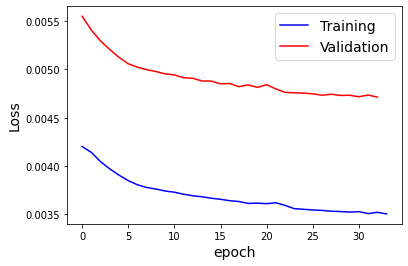

In [6]:
plot_learning_curve(train_history,val_history)

Vemos que obtenemos un accuracy bastante bajo (cercano al 50%) y que el modelo no es capaz de generalizar (loss de validación muy alto). Esto es porque la técnica **Pixel as Features** utiliza como características las propias intensidades. No utiliza información de vecindad ni estadísticos de orden superior. En la siguiente sesión del curso, veremos que esto tiene dos soluciones:
1. Extraer características predeterminadas de las imágenes (intensidad media, varianza....) en diferentes partes de cada images y utilizamos esas características a la entrada del MLP
2. Utilizar una red neuronal que sea capaz de extraer características ad-hoc, que resulten suficientemente descriptivas para el problema que estamos tratando :)


Una vez entrenado el modelo, estimamos su capacidad de generalización con el dataset de test.
Para poder calcular la curva ROC necesitamos un score y la etiqueta "ground truth". El score lo obtenemos restando los dos valores que proporciona softmax (la activación para cada neurona de salida).
Almacenamos estos scores en la variable *scores*, y guardamos las etiquetas "ground truth" en *lab_mat* así como las predicciones de la red en *pred_mat*

In [7]:
dataset_test = ImageFolder(root='/content/data/Variedades-JPG/VALIDACION_45_GREYSCALE',transform=transforms.ToTensor())
# Creamos el dataloader
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=500, shuffle=False)
correct = 0
total = 0

with torch.no_grad():       # hay que deshabilitar la propagación de gradiente
    for i, (images, labels) in enumerate(test_loader,0):
        outputs = model(images.to('cuda'))                 # Propagación hacia delante
        _, predicted = torch.max(outputs, 1)    # obtención de etiquetas numéricas
        total += labels.size(0)                 # aumentamos el número de etiquetas comprobadas para calcular la precisión después
        correct += torch.sum(predicted == labels.to('cuda')).item() # sumamos el número de etiquetas correctas para calcular la precisión
        if i==0:
            pred_mat=predicted.detach().cpu().numpy()
            lab_mat=labels.detach().cpu().numpy()
            scores=np.diff(outputs.detach().cpu().numpy()).flatten()
        else:
            pred_mat=np.hstack((pred_mat,predicted.detach().cpu().numpy()))
            lab_mat=np.hstack((lab_mat,labels.detach().cpu().numpy()))
            scores=np.hstack((scores,np.diff(outputs.detach().cpu().numpy()).flatten()))


print(f'Precisión del modelo en las imágenes de test: {correct / total}')

Precisión del modelo en las imágenes de test: 0.5971428571428572
